# 🧠 Micrograd from Scratch
This notebook is a minimal implementation of a neural network and autodiff engine implemented using Andrej Karpathy's [youtube video](https://youtu.be/VMj-3S1tku0?si=cj5Y_3hU52T-JLBn) on the same.

It includes:
- Implementation of a `Value` class for reverse-mode autodiff
- Construction of a tiny neural network
- Manual training loop using a very basic gradient descent

> 📌 Written fully from scratch using only Python.


In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 🔧 Value Class
This is the core of our autodiff engine. It supports basic operations and tracks gradients.

In [3]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''): # an empty tuple of children to know what created that particular value & _op for the operation plus a label
        self.data = data
        self.grad = 0.0 # this initialisation shows that this value initially does not affect. it means dL / dx where x is the variable.
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # to prevent the case of a + 1 being an error cause 1 is int and a is object called Value
        out = Value(self.data + other.data, (self, other), '+') # feeding self and other one into the children set
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward       
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # it will check tht if 2.__mul__(a) not possible then is a.__mul__(2) possible?
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
        
    def __truediv__(self, other):
        return self * other ** -1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), label = 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
            
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

# simple mathematical expressions to test our Object.
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
L
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

## 📊 Digraph for representation
It is used to visualise every calculation we do during the training for a NN. You can try it by `draw_dot(n(x))` where `n` is your NN.

In [4]:
from graphviz import Digraph

def trace(root):

    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data = %.4f | grad = %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

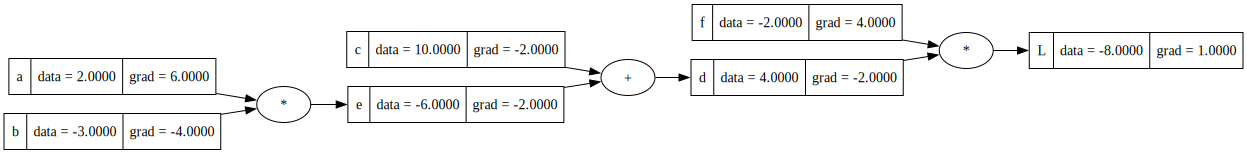

In [5]:
draw_dot(L)

In [8]:
#Using vectors

x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(6.8813735870195432, label = 'b')
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'output'


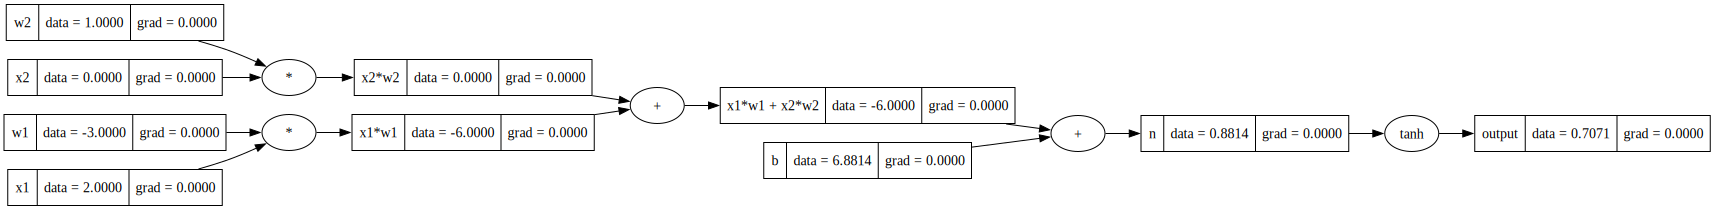

In [9]:
draw_dot(o)

### For gradients calculations
- We have to store everything after that node before calling any particular node's ._backward so to connect the graphs we use topological.sort
- also called ordering of graphs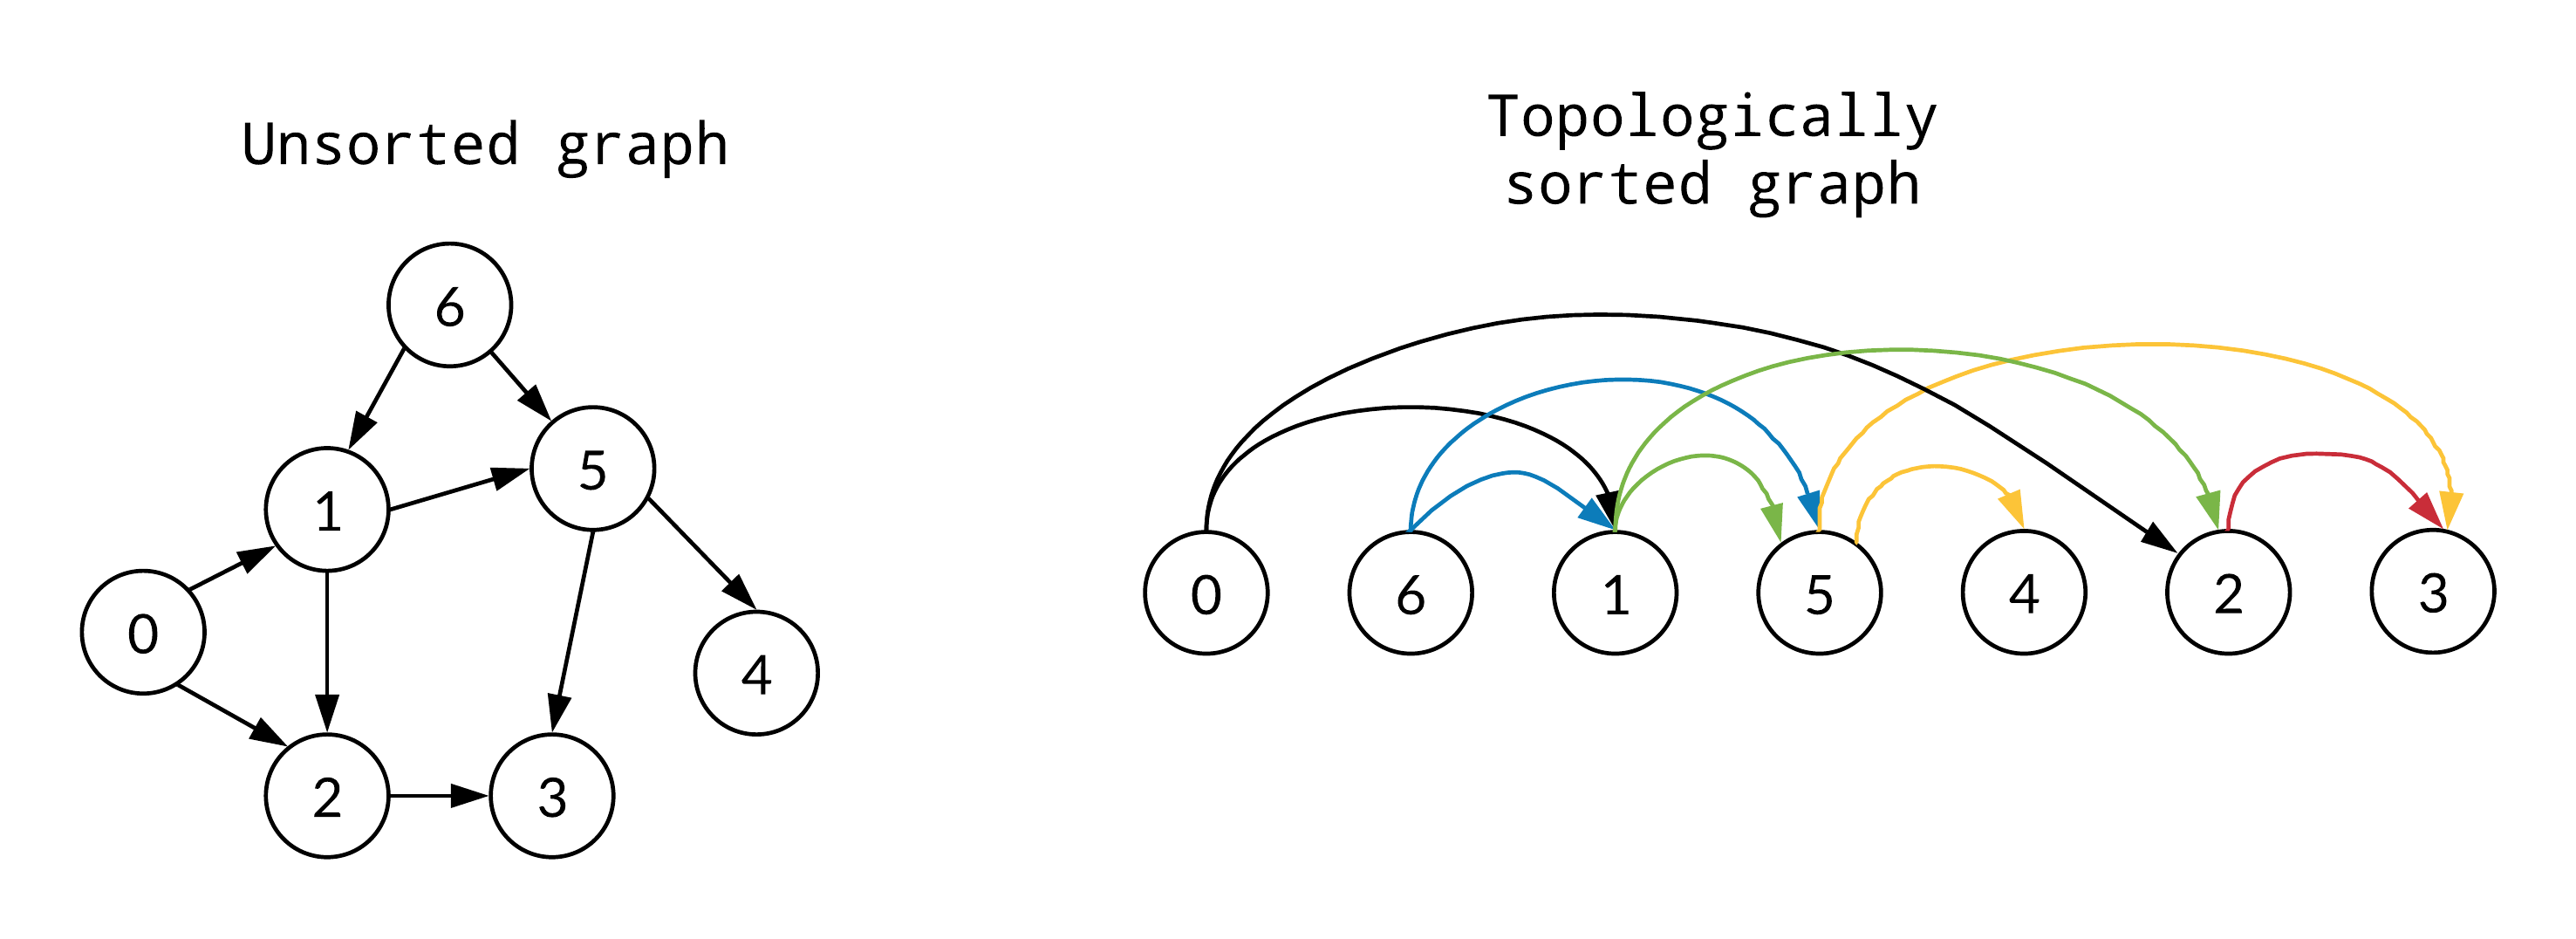

In [10]:
o.backward()

*BUT* There is a bug, say you have a = 3.0 and b = 2 * a but you wrote a bit differently

In [11]:
a = Value(2.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)
a.exp()
a / b
a - 2

Value(data=0.0)

The a.grad should be 2 and not 1!!
so we solve this by multivariable case which says to accumulate all the derivatives before.

## 🧩 Neuron, Layer, and MLP
These classes define the structure of our neural network.

In [12]:
class Neuron:

    def __init__(self, nin): #nin -> dimension like nin = 2 is 2d
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b) #now sum takes initiator as 0.0 but we set that as self.b
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:

    def __init__(self, nin, nout): #nout-> no. of neurons for a layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params # or one line return [p for neuron in self.neurons for p in neuron.parameters()] 


class MLP:

    def __init__(self, nin, nouts):#nouts -> a list which defines the size of each lLayer
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

        

In [13]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6310628439322978)

In [14]:
x_train = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

y_train = [1.0, -1.0, -1.0, 1.0]


## 🏋️ Training Loop
We train the model using manual gradient descent and backpropagation.

In [19]:
for k in range(20):
    #forward pass
    y_pred = [n(x) for x in x_train]
    loss = sum(((y_pred_i - y_train_i)**2 for y_train_i, y_pred_i in zip(y_train, y_pred)), start = Value(0.0))

    #backward pass
    for p in n.parameters(): # a very subtle bug (if missed) which can make a huge difference for big datasets
        p.grad = 0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 0.004711037717816295
1 0.004642581009450574
2 0.004576087577428788
3 0.004511473683568351
4 0.004448660322943345
5 0.004387572890919519
6 0.004328140878205524
7 0.004270297591177143
8 0.004213979895038031
9 0.004159127977647149
10 0.0041056851320797755
11 0.004053597556193002
12 0.004002814167650561
13 0.003953286433019932
14 0.003904968209697944
15 0.0038578155995453384
16 0.0038117868132226287
17 0.0037668420443178864
18 0.0037229433524456523
19 0.003680054554573716


In [20]:
y_pred

[Value(data=0.97098766325113),
 Value(data=-0.9677970165751208),
 Value(data=-0.9760456874329126),
 Value(data=0.9649643376126679)]

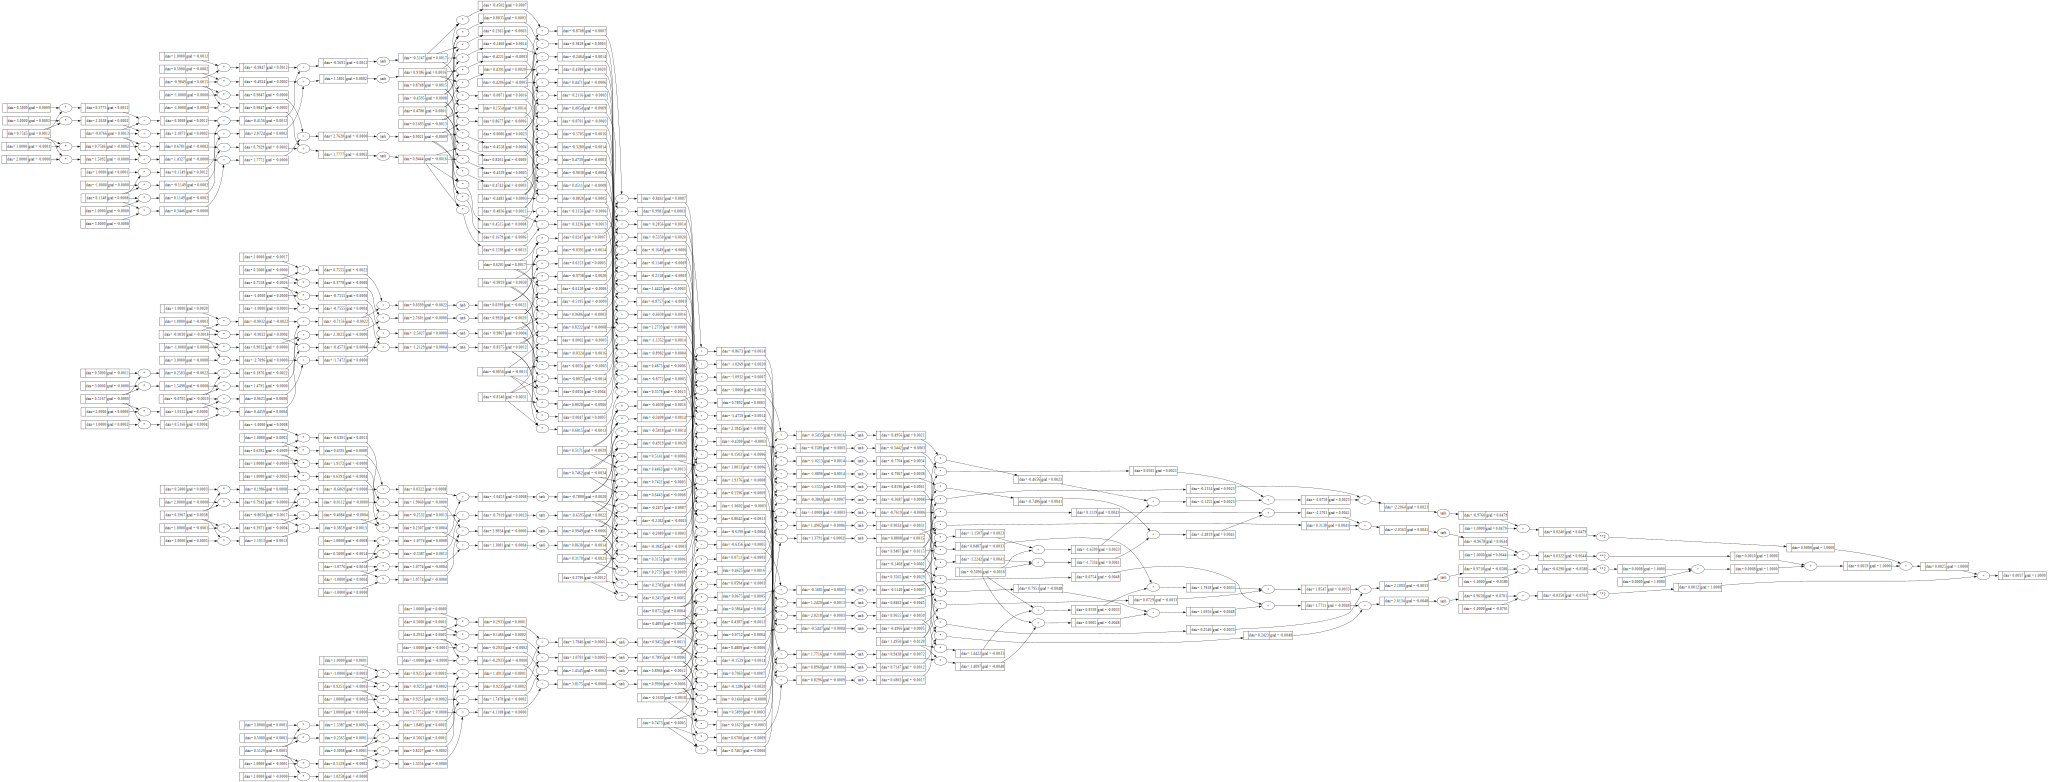

In [21]:
draw_dot(loss)